You can either download this notebook and run it locally, or you can run them in the cloud:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://colab.research.google.com/github/kirbyju/TCIA_Notebooks/blob/main/TCIA_RTStruct_SEG_Visualization_with_itkWidgets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github.com/kirbyju/TCIA_Notebooks/blob/main/TCIA_RTStruct_SEG_Visualization_with_itkWidgets.ipynb)

# Summary
Access to large, high quality data is essential for researchers to understand disease and precision medicine pathways, especially in cancer. However HIPAA constraints make sharing medical images outside an individual institution a complex process. [The Cancer Imaging Archive (TCIA)](https://www.cancerimagingarchive.net/) is a public service funded by the National Cancer Institute which addresses this challenge by providing hosting and de-identification services to take major burdens of data sharing off researchers.

## DICOM Image Objects
Most of TCIA data is available as DICOM objects.  A wide variety of toolkits are able to read DICOM images, but fewer are able to convert them into volumetric representations, and still fewer correctly maintain the meta-data necessary to interpret how that volume maps into physical space (i.e., its origin, axis orientation, and the physical distance between its voxels).   Such information is critical to subsequent analysis of those images.

[ITK](https://github.com/InsightSoftwareConsortium/ITK) is used to read DICOM images.

## DICOM SEG and RTStruct Objects
There are often DICOM SEG (labelmap) and DICOM RTStruct (contour) files that provide annotations for the DICOM images.  Reading and mapping those objects onto medical images, and converting contours to labelmaps and preserving the origin, spacing, and direction information in those labelmaps can also be challenging.

Herein, we explore a common AI research workflow.  We demonstrate basic methods for downloading DICOM objects from TCIA, converting them into images and labelmaps, and visualizing them within this jupyter notebook using itkWidgets.   

[RT-Utils](https://github.com/qurit/rt-utils) (built on top of pydicom) is used to convert RTStruct contours to labelmaps.

[pydicom-seg](https://github.com/razorx89/pydicom-seg) (also built on top of pydicom) is used to convert SEG labelmaps to images.

## Visualization
While jupyter systems (jupyter labs, jupyter notebooks, Google CoLab, AWS SageMaker, etc.) are outstanding tools for interactive programming and algorithm sharing, the ability to visualize data within them has traditionally be limited to plots and sparse 2D slices - which are insufficient when dealing with 3D clinical data. This limitation is particularly challenging when using cloud-based jupyter systems such as Google CoLab and AWS Sagemaker. 3D interactive visualization of data when using those cloud systems traditionally requires downloading that data to your local machine and then running a separate visualization application. itkWidgets addresses those visualization challenges by providing interacitve 3D (and 2D) visualizations within the cells of your jupyter scripts.

[itkWidgets](https://github.com/InsightSoftwareConsortium/itkwidgets) is used to visualize images, point sets, and 3D geometry in Jupyter systems (Jupyer notebooks, Jupyter lab, AWS Sagemaker, and Google CoLab). Despite its name, itkWidgets does not require the use of ITK. It can directly visualization numpy arrays, torch tensors, DASK arrays, VTK polydata, and a multitude of other python data structures.

# Outline

1. TCIA Basics
2. itkWidgets Basics
3. Use Cases
    1. Load and visualize DICOM Images and RTStruct objects from TCIA
    2. Load and visualize DICOM Images and SEG objects from TCIA

# 1 TCIA Basics

[Browsing Collections](https://www.cancerimagingarchive.net/collections) and [Analysis Results](https://www.cancerimagingarchive.net/tcia-analysis-results/) datasets on TCIA are the easiest ways to become familiar with what is available.  These pages will help you quickly identify datasets of interest, find valuable supporting data that are not available via our APIs (e.g. clinical spreadsheets, non-DICOM segmentation data), and answer most common questions you might have about the datasets.  

If you are new to accessing TCIA via notebooks you can find additional tutorials on querying and downloading data at https://github.com/kirbyju/TCIA_Notebooks.

In [1]:
# Install the common libraries for importing DICOM data from
#   TCIA into jupyter systems.

# Upgrade pip, just in case...
import sys
!{sys.executable} -m pip install --upgrade -q pip

# Install pandas for managing TCIA manifests and 
#    downloaded data.
!{sys.executable} -m pip install --upgrade -q pandas

# Install itk for DICOM I/O and for reading DICOM into an itkImage 
#   that manages all DICOM field values, include acquistion details 
#   such as voxel image, image orientation, and image directions
#   which are critical to image processing and display
!{sys.executable} -m pip install --upgrade --pre -q itk

# Install rt-utils for reading DICOM RT-Struct objects
!{sys.executable} -m pip install --upgrade -q rt-utils

# Install pydicom-seg for reading DICOM SEG objects
!{sys.executable} -m pip install --upgrade -q pydicom-seg

In [2]:
# For path functions
import os

# Import the libaries we installed for TCIA
import requests
import json
import requests, zipfile
import pandas as pd
from io import BytesIO

# Include ITK for DICOM reading
import itk

# Include numpy which is used by pydicom-seg and rt_utils
import numpy as np

# Pydicom-Seg is a layer on top of pydicom that handles DICOM SEG objects.
import pydicom
import pydicom_seg

# RT-Utils is a layer on top of pydicom that provides a convenient way to read RT-STRUCT DICOM contours and
#   generate labelmaps from them.  Labelmaps are needed for most deep learning segmentation tasks
from rt_utils import RTStructBuilder

In [3]:
# Download a "Shared Cart" that has been previously created via the NBIA webset (https://nbia.cancerimagingarchive.net)
cartName = "nbia-49121659384603347"

cart_URL = "https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName?name=" + cartName
cart_data = requests.get( cart_URL ).json()

# Convert the metadata downloaded to a pandas dataframe for easy access and manipulation
df = pd.DataFrame( cart_data )

display(df)

# Here are the series UIDs that correspond to the series in that study
series_uids = [ seriesUID for seriesUID in df['SeriesInstanceUID'] ]

# Go through the Series in the cart, and download them
TCIA_base_url = "https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?SeriesInstanceUID="
dicom_data_dir = "dicomData/"
for num,series_uid in enumerate(series_uids):
        path = dicom_data_dir + series_uid
        if not os.path.isdir(path):
            print( f"Downloading series {num+1} of {len(series_uids)}: {series_uid}")
            request = requests.get( TCIA_base_url + series_uid )
            file = zipfile.ZipFile( BytesIO(request.content) )
            file.extractall( path )
            print("   ...done.")
        else:
            print(f"Series {num+1} of {len(series_uids)} already downloaded.")

,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDate,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,PatientID,Manufacturer,ManufacturerModelName,SoftwareVersions,ImageCount,ProtocolName
0,1.2.276.0.7230010.3.1.3.1070885483.15960.15991...,1.3.6.1.4.1.14519.5.2.1.7311.5101.170561193612...,SEG,2020-09-03 00:00:00.0,Segmentation,PROSTATE,300,PROSTATEx,ProstateX-0004,QIICR,https://github.com/qiicr/dcmqi.git,1e82977,1,NaN
1,1.3.6.1.4.1.14519.5.2.1.1446730703023542404050...,1.3.6.1.4.1.14519.5.2.1.8859670961354389003042...,RTSTRUCT,NaN,RTSTRUCT,NaN,2,Pediatric-CT-SEG,Pediatric-CT-SEG-00DCF4D6,Varian Medical Systems,ARIA RTM,4.2.7.0,1,NaN
2,1.3.6.1.4.1.14519.5.2.1.6673411903393211051343...,1.3.6.1.4.1.14519.5.2.1.8859670961354389003042...,CT,2009-10-09 00:00:00.0,CT,ABDOMEN,30144,Pediatric-CT-SEG,Pediatric-CT-SEG-00DCF4D6,GE MEDICAL SYSTEMS,Revolution CT,revo_ct_21a.33,207,NaN
3,1.3.6.1.4.1.14519.5.2.1.7311.5101.206828891270...,1.3.6.1.4.1.14519.5.2.1.7311.5101.170561193612...,MR,2011-10-18 00:00:00.0,t2_tse_tra,PROSTATE,5,PROSTATEx,ProstateX-0004,SIEMENS,Skyra,syngo MR D11,19,t2_tse_tra


Series 1 of 4 already downloaded.
Series 2 of 4 already downloaded.
Series 3 of 4 already downloaded.
Series 4 of 4 already downloaded.


# 2. itkWidget Basics

[itkWidgets documentation](https://itkwidgets.readthedocs.io/en/latest/?badge=latest) provides a summary and illustrations of itkWidgets for a wide variety of scientific data visualization use cases.  Here we focus on its application to data on TCIA.

In [4]:
# This is the installation required for itkWidgets
!{sys.executable} -m pip install --upgrade --pre -q itkwidgets[all]

In [5]:
# This is the most common import command for itkWidgets.
#   The view() function opens an interactive viewer for 2D and 3D
#   data in a variety of formats.
from itkwidgets import view

# 3 Use cases
In this section we'll download a few datasets from TCIA to show off the functionality of ITK and itkWidgets by demonstrating the following use cases:

3.A. Load and visualize DICOM Image and RTStruct objects from TCIA<br>
3.B. Load and visualize DICOM Image and SEG objects from TCIA<br>

## 3.A. Load and visualize DICOM Image and RTStruct objects from TCIA

### 3.A.1. Identify CT and RTSTRUCT data from the Pediatric-CT-SEG study

In [6]:
# The Pediatric-CT-SEG study provides DICOM images and DICOM RTSTRUCT data
ped_study_df = df.query( 'Collection=="Pediatric-CT-SEG"')

# The series_uid defines their directory where the CT data was stored on disk
ped_ct_series_uid = ped_study_df.SeriesInstanceUID[ped_study_df.Modality.eq('CT').idxmax()]
ped_ct_dir = dicom_data_dir + ped_ct_series_uid

# The series_uid defines where the RTSTRUCT was stored on disk.  It is stored in a single file.
ped_rtstruct_series_uid = ped_study_df.SeriesInstanceUID[ped_study_df.Modality.eq('RTSTRUCT').idxmax()]
ped_rtstruct_file = dicom_data_dir + ped_rtstruct_series_uid + "/00000001.dcm"

### 3.A.2. Read and visualize CT and RTSTRUCT data from the Pediatric-CT-SEG study

In [7]:
# Read the DICOM CT series' objects and reconstruct them into a 3D ITK image
#   The itk.F option is added to store the image in memory using floating-point precision pixels (useful if you will filter the image or use it with MONAI)
#   For more info on imread, see https://itkpythonpackage.readthedocs.io/en/master/Quick_start_guide.html 
ped_ct_image = itk.imread(ped_ct_dir, itk.F)

# We use RT-Utils to read in the list of contours (ROIs) available in the RT-STRUCT file.  This also requires passing-in the path to the original
#   DICOM series (image) so that labelmaps images can be generated from the RT-STRUCT contours.
ped_rtstruct = RTStructBuilder.create_from(dicom_series_path=ped_ct_dir, rt_struct_path=ped_rtstruct_file)

# RT-Utils has many useful functions, including the ability to list the names of the ROIs available in the RT-STRUCT file
print(ped_rtstruct.get_roi_names())

['Bones', 'Skin', 'Lung_R', 'UteroCervix', 'Thymus', 'Stomach', 'Spleen', 'Spinal Canal', 'Small Intestine', 'Rectum', 'Prostate', 'Pancreas', 'Liver', 'Large Intestine', 'Kidney Right', 'Kidney Left', 'Heart', 'Gonads', 'Gall Bladder', 'Femoral Head Rig', 'Femoral Head Lef', 'Esophagus', 'Duodenum', 'Breast Right', 'Breast Left', 'Bladder', 'Adrenal Right', 'Adrenal Left', 'Lung_L']


In [8]:
# Read in the bones contour as a numpy array.  We must also convert convert it to float (for possible future filtering, MONAI, etc.), and realign the axis to 
#   correspond with how images are stored by ITK.  This realignment typically isn't needed, but rt-utils requires it.
#   Note: The copy() call is required to force the transpose to actually reorder the data in memory versus maintain an abstraction.
ped_bones_array = ped_rtstruct.get_roi_mask_by_name("Bones").astype(np.float32).transpose(2,0,1).copy()
# As an np array, the rtstruct labelmap is missing critical information about pixel spacing, image origin, image orientation, etc.
#    Here we create an itk image from the numpy array, and we copy the critical information from itk image created from the 
#    original DICOM CT data.
ped_bones_labelmap = itk.GetImageFromArray(ped_bones_array)
ped_bones_labelmap.CopyInformation(ped_ct_image)


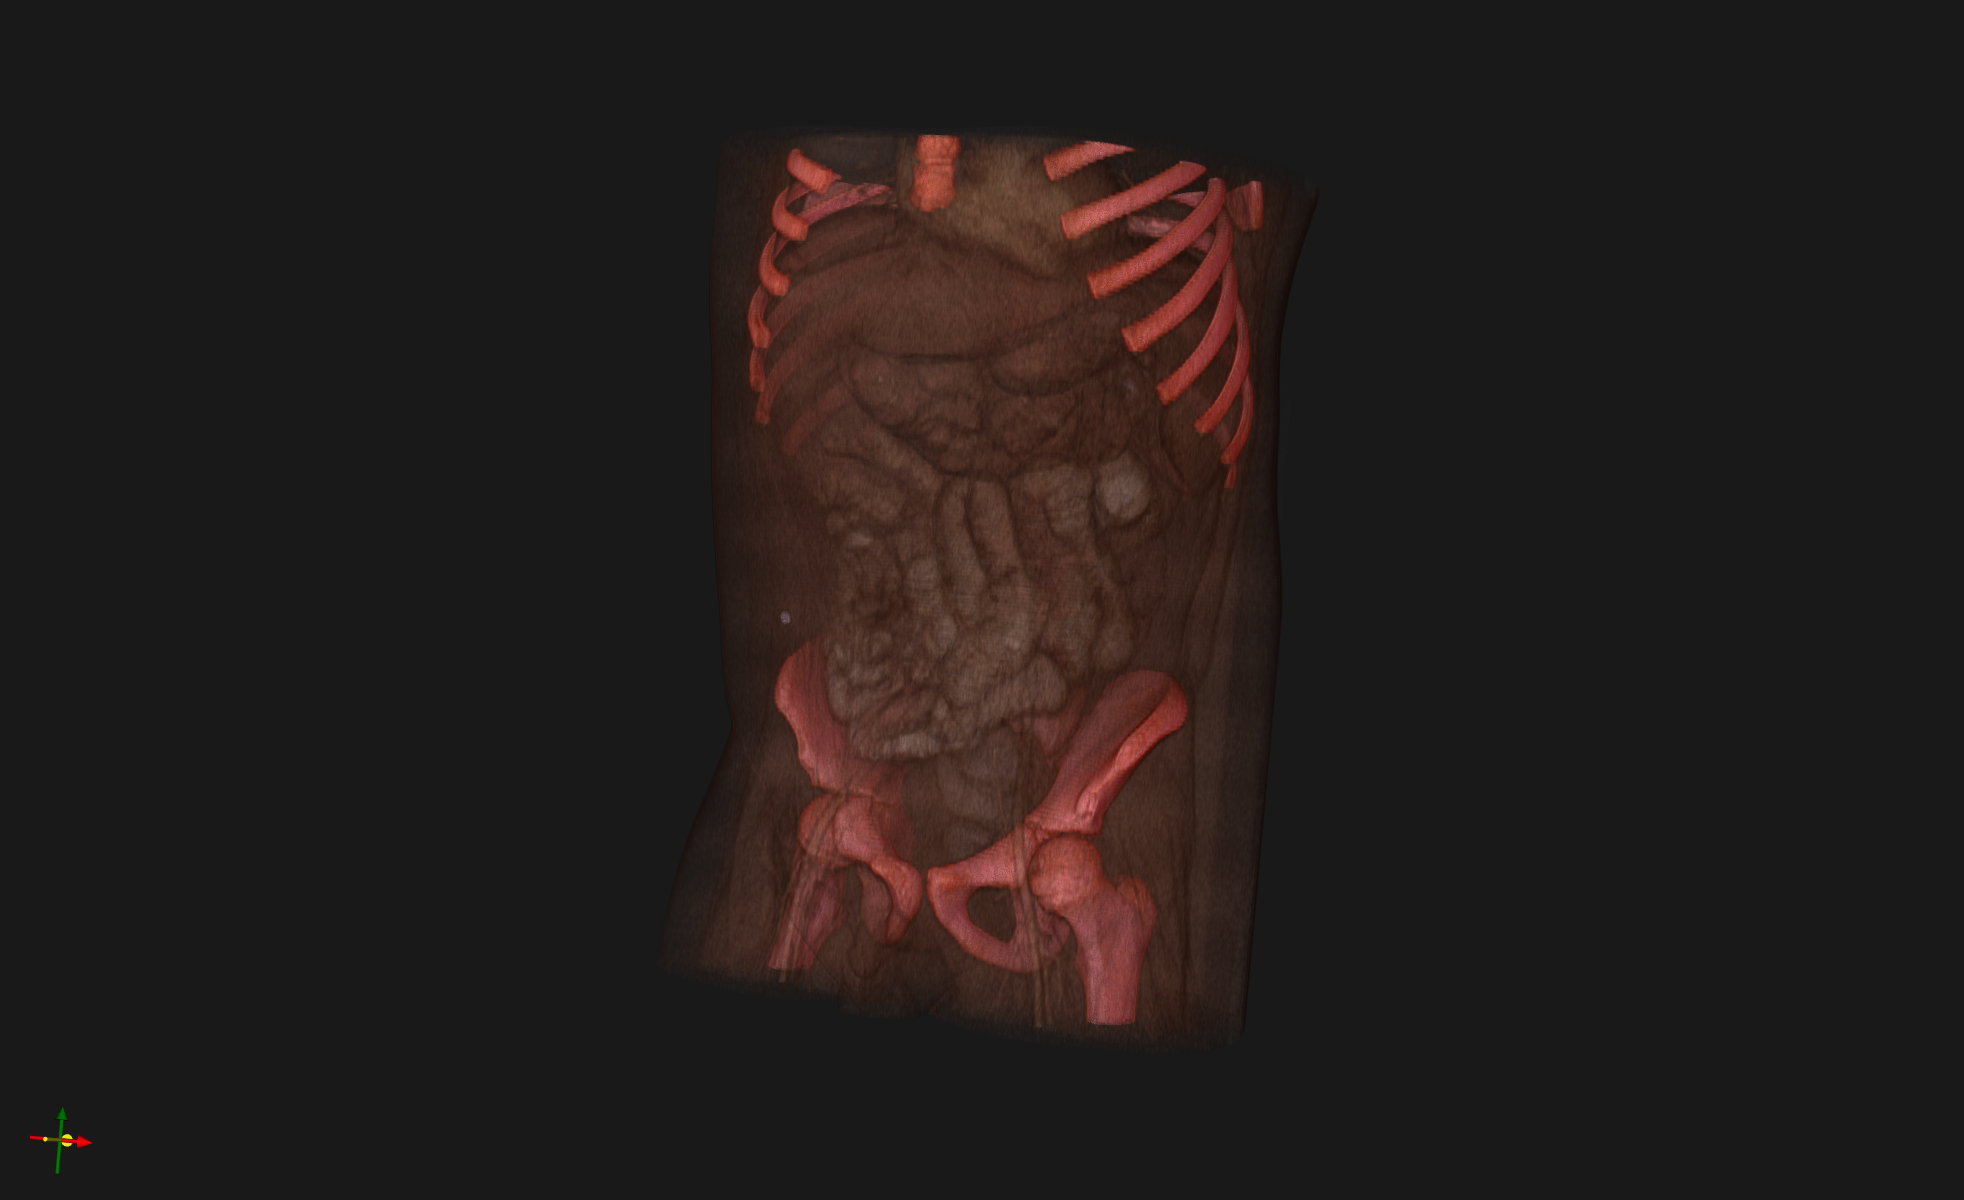
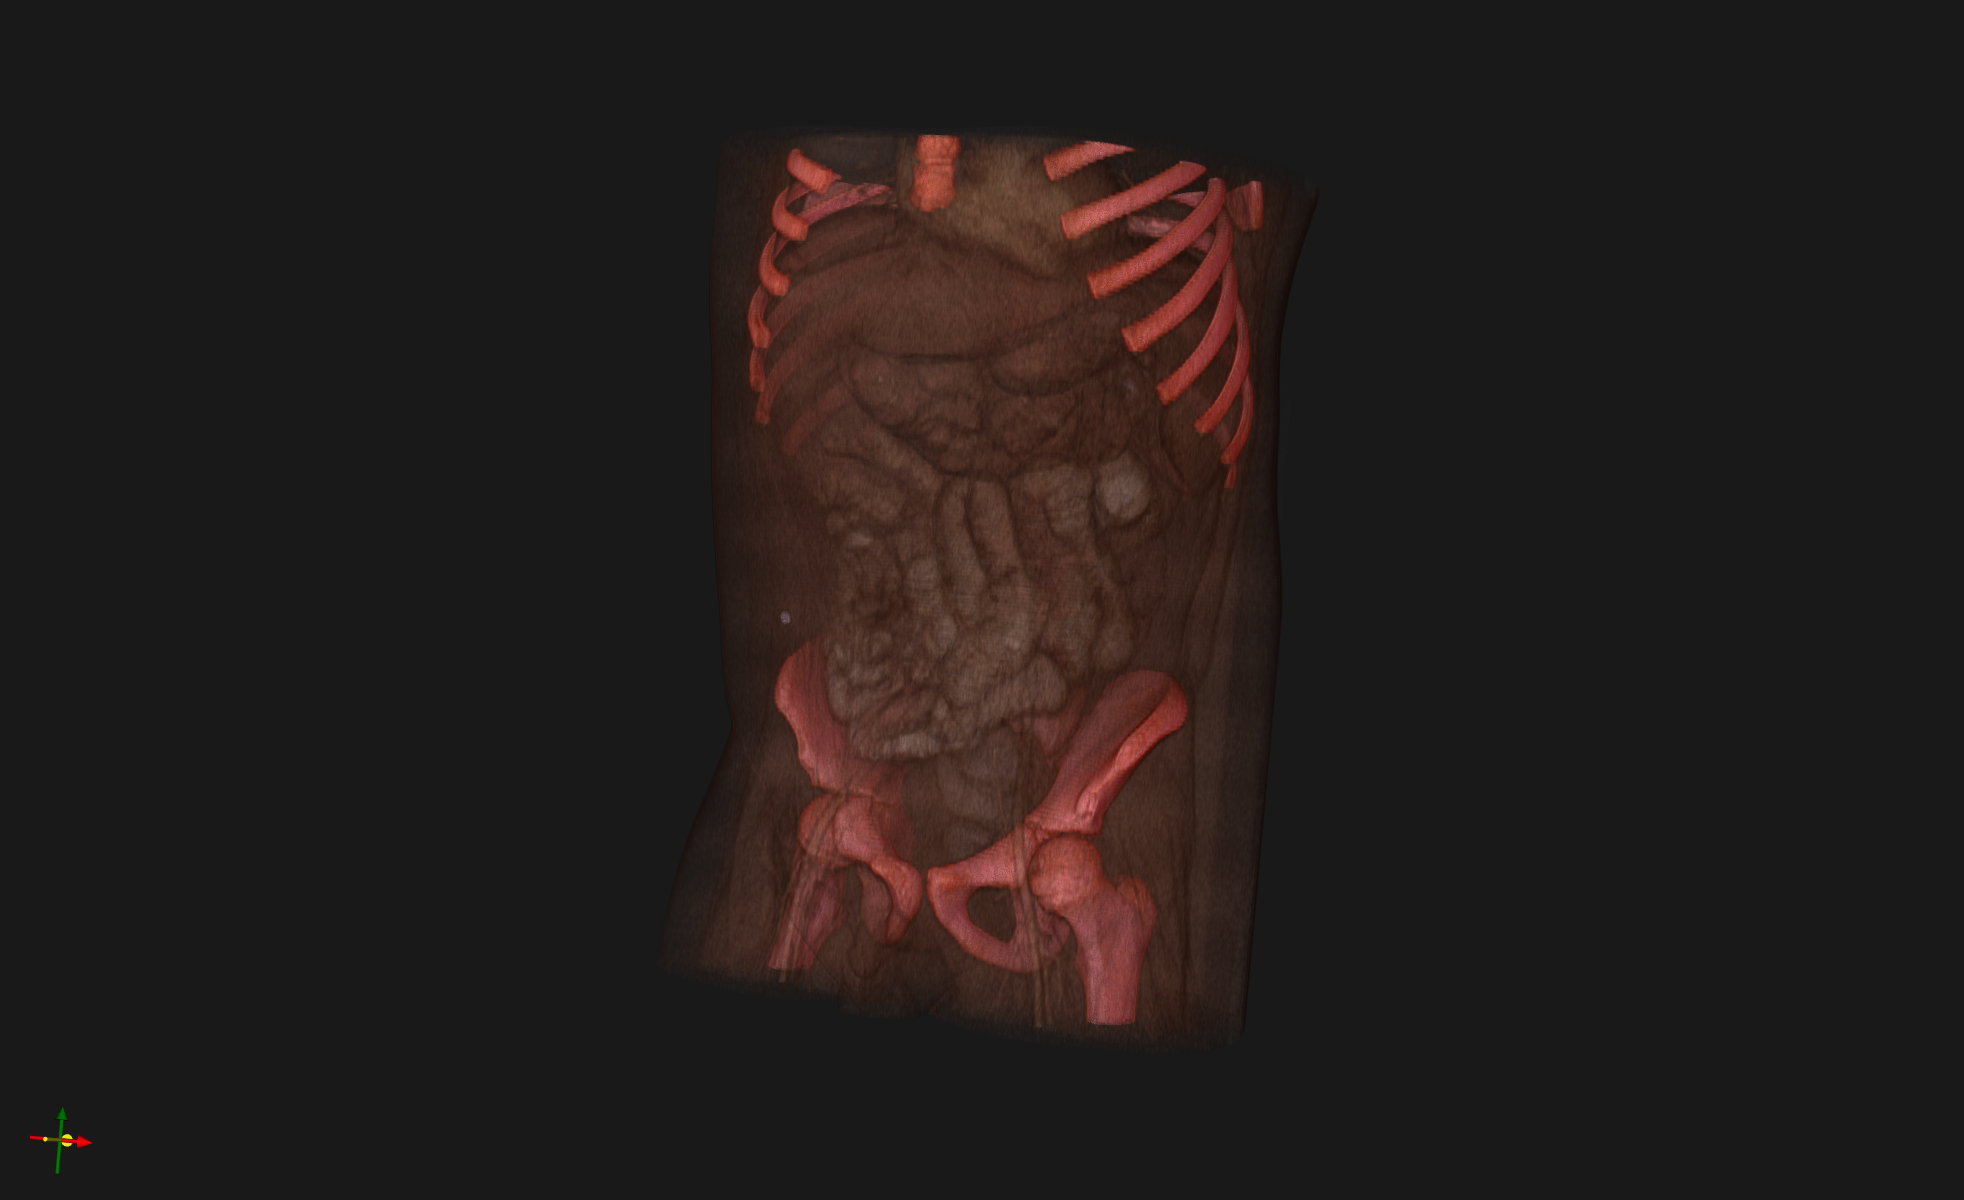

<IPython.core.display.Javascript object>

In [16]:
# This generates a default 3D visualization, with the bone labelmap coloring the bones "red" 

viewerA = view(image=ped_ct_image, label_image=ped_bones_labelmap)

In [17]:
# Please wait for the data to be fully loaded and visualized in the frame above before continuing.
#    itkWidgets is an asynchronous system: you can interact with the data as it is being loaded,
#    but programmatically changing rendering parameters (as done in the next cell) as the data is 
#    being loaded can produce unexpected results...

# If the data has been fully loaded, you can skip this cell.
import time
time.sleep(20)

In [23]:
# Here we demonstrate how to programmatically set some of the common volume rendering options
viewerA.set_background_color([0.1,0.1,0.1])
viewerA.set_image_color_map("CT-Muscle")
viewerA.set_image_gradient_opacity(0.425)
viewerA.set_image_color_range([-500,1000])
viewerA.set_rotate(True)

In [12]:
# In case you haven't seen it, here we open the user interface panel so that you can manually manipulate the visualization
viewerA.set_ui_collapsed(False)

# For example, clicking on the colored cubes in the second row  in this panel will switch to a 2D view with the labelmap overlaid.

## 3.B. Load and visualizing DICOM image and SEG objects from TCIA

### 3.B.1. Identify MR and SEG data from the PROSTATEx study

In [13]:
# The PROSTATEx study provides DICOM images and DICOM SEG data
pro_study_df = df.query( 'Collection=="PROSTATEx"' )

# The series_uid defines their directory where the MR data was stored on disk
pro_mr_series_uid = pro_study_df.SeriesInstanceUID[pro_study_df.Modality.eq('MR').idxmax()]
pro_mr_dir = dicom_data_dir + pro_mr_series_uid

# The series_uid defines where the RTSTRUCT was stored on disk.  It is stored in a single file.
pro_seg_series_uid = pro_study_df.SeriesInstanceUID[pro_study_df.Modality.eq('SEG').idxmax()]
pro_seg_file = dicom_data_dir + pro_seg_series_uid + "/00000001.dcm"

In [14]:
# Read the DICOM MR series' objects and reconstruct them into a 3D ITK image
#   The itk.F option is added to store the image in memory using floating-point precision pixels (useful if you will filter the image or use it with MONAI)
#   For more info on imread, see https://itkpythonpackage.readthedocs.io/en/master/Quick_start_guide.html 
pro_mr_image = itk.imread(pro_mr_dir, itk.F)

# Read the DICOM SEG object using pydicom and pydicom_seg
pro_seg_dicom = pydicom.dcmread(pro_seg_file)
seg_reader = pydicom_seg.MultiClassReader()
pro_seg_obj = seg_reader.read(pro_seg_dicom)

# Convert the DICOM SEG object into an itk image, with correct voxel origin, spacing, and directions in physical space
pro_seg_image = itk.GetImageFromArray(pro_seg_obj.data.astype(np.float32))
pro_seg_image.SetOrigin(pro_seg_obj.origin)
pro_seg_image.SetSpacing(pro_seg_obj.spacing)
pro_seg_image.SetDirection(pro_seg_obj.direction)


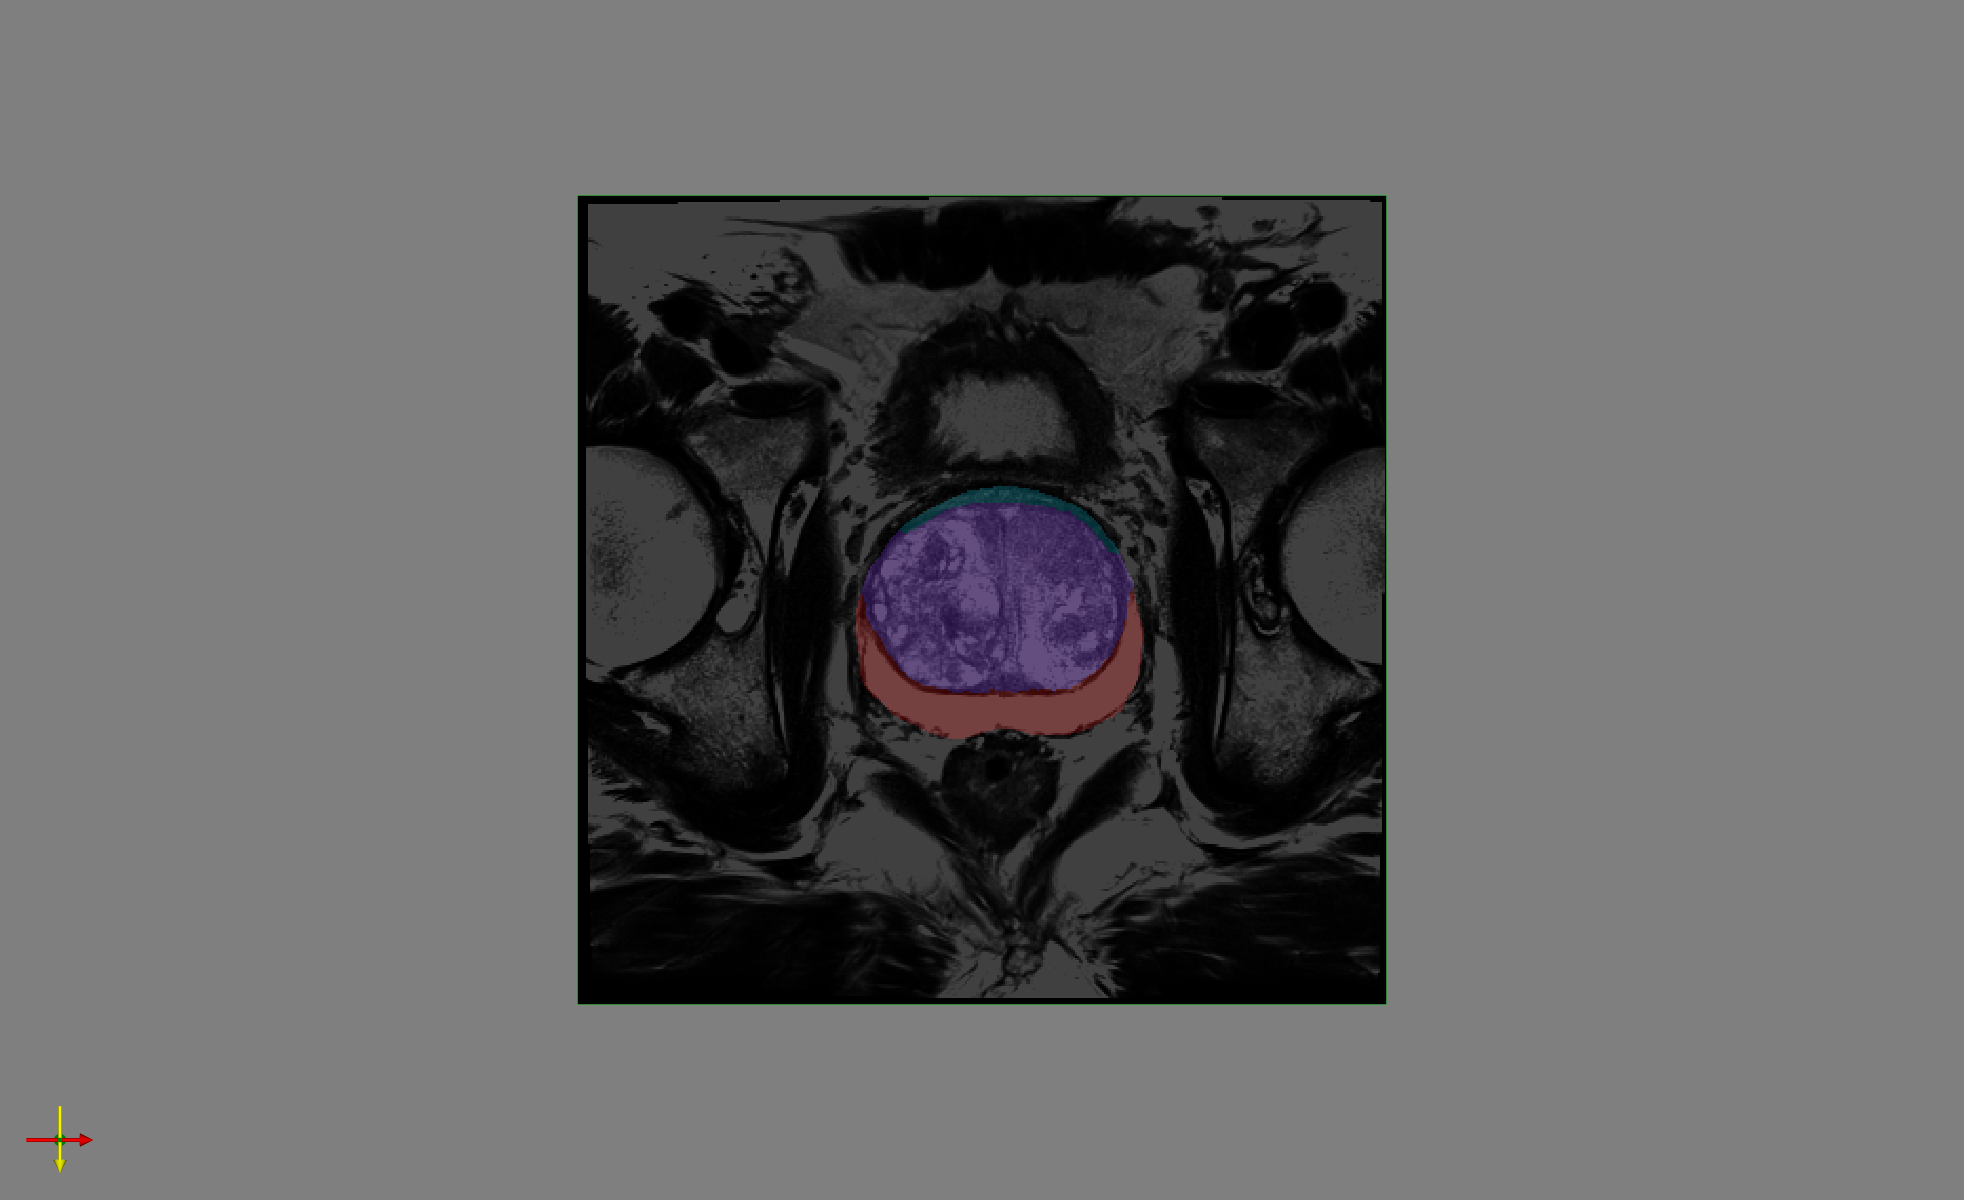
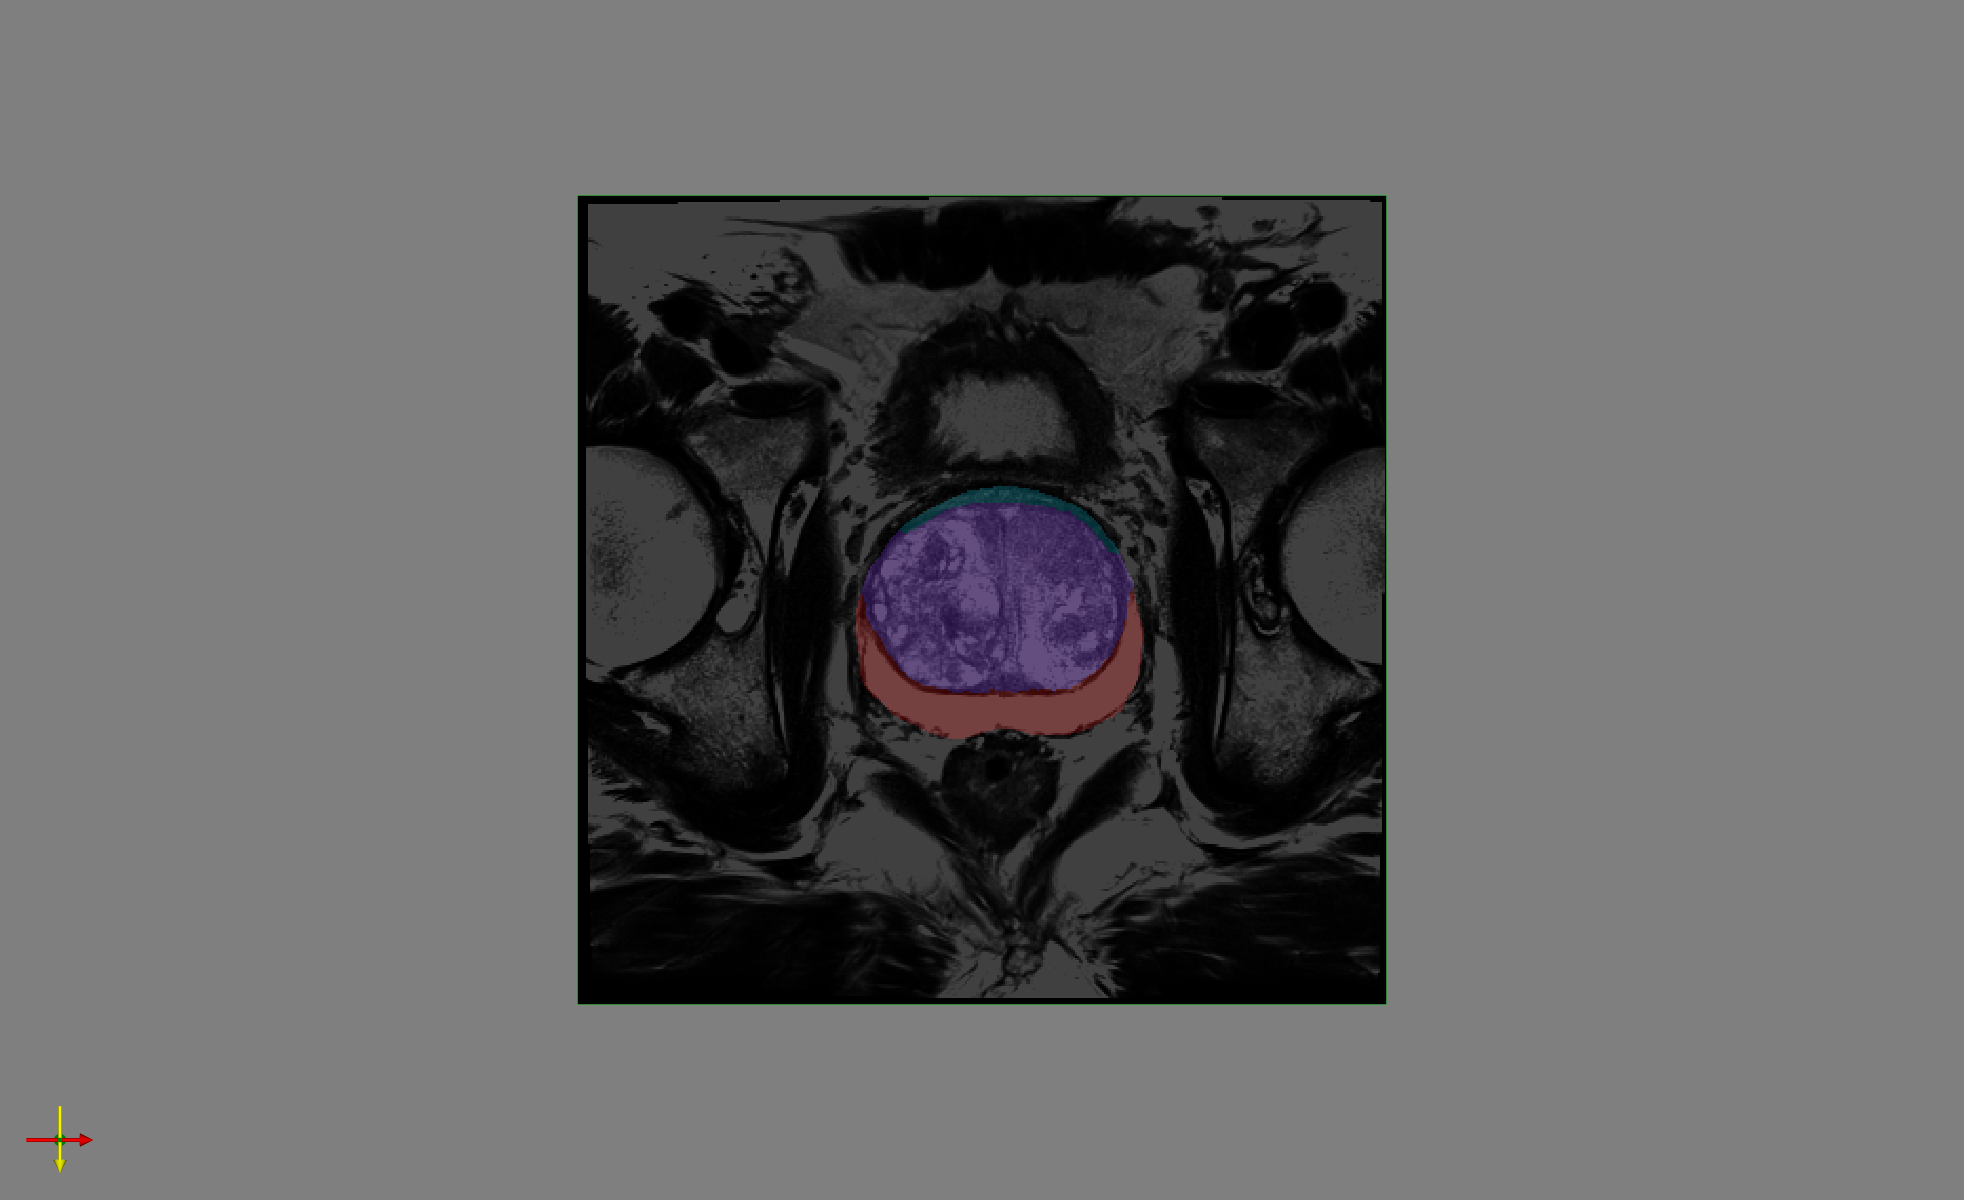

<IPython.core.display.Javascript object>

In [15]:
viewerB = view(image=pro_mr_image, 
               label_image=pro_seg_image)
viewerB.set_image_color_map("Grayscale")
viewerB.set_image_color_range([0,400])
viewerB.set_view_mode("ZPlane")
viewerB.set_z_slice(53)
viewerB.set_ui_collapsed(False)

# Acknowledgements

TCIA is funded by the [Cancer Imaging Program (CIP)](https://imaging.cancer.gov/), a part of the United States [National Cancer Institute (NCI)](https://www.cancer.gov/), and is managed by the [Frederick National Laboratory for Cancer Research (FNLCR)](https://frederick.cancer.gov/).

If you leverage this notebook or any TCIA datasets in your work please be sure to comply with the [TCIA Data Usage Policy](https://wiki.cancerimagingarchive.net/x/c4hF). In particular, make sure to cite the DOI(s) for the specific TCIA datasets you used in addition to TCIA citation provided below!

This notebook was created by [Stephen Aylward (Kitware)](https://www.kitware.com/stephen-aylward/), [Justin Kirby (Frederick National Laboratory for Cancer Research](https://www.linkedin.com/in/justinkirby82/), Qinyan Pan, [Brianna Major (Kitware)](https://www.kitware.com/brianna-major/), and [Matt McCormick (Kitware)](https://www.kitware.com/matt-mccormick/).

If you have any questions, suggestions, or issues with itkWidgets, please post them on the [itkwidget issue tracker](https://github.com/InsightSoftwareConsortium/itkwidgets/issues) or feel free to email us at kitware@kitware.com.

## Data Citation
Some of the data used in this notebook was part of the Pediatric-CT-SEG collection:

Jordan, P., Adamson, P. M., Bhattbhatt, V., Beriwal, S., Shen, S., Radermecker, O., Bose, S., Strain, L. S., Offe, M., Fraley, D., Principi, S., Ye, D. H., Wang, A. S., Van Heteren, J., Vo, N.-J., & Schmidt, T. G. (2021). Pediatric Chest/Abdomen/Pelvic CT Exams with Expert Organ Contours (Pediatric-CT-SEG) (Version 2) [Data set]. The Cancer Imaging Archive. https://doi.org/10.7937/TCIA.X0H0-1706

Some of the data used in this notebook was part of the ProstateX challenge:

Geert Litjens, Oscar Debats, Jelle Barentsz, Nico Karssemeijer, and Henkjan Huisman. "ProstateX Challenge data", The Cancer Imaging Archive (2017). DOI: 10.7937/K9TCIA.2017.MURS5CL

## Publication Citation
Some of the data used in this notebook was part of the Pediatric-CT-SEG collection:

Jordan, P., Adamson, P. M., Bhattbhatt, V., Beriwal, S., Shen, S., Radermecker, O., Bose, S., Strain, L. S., Offe, M., Fraley, D., Principi, S., Ye, D. H., Wang, A. S., Heteren, J., Vo, N., & Schmidt, T. G. (2022). Pediatric chest‐abdomen‐pelvis and abdomen‐pelvis CT images with expert organ contours. In Medical Physics (Vol. 49, Issue 5, pp. 3523–3528). Wiley. https://doi.org/10.1002/mp.15485

Some of the data used in this notebook was part of the ProstateX challenge:

Litjens G, Debats O, Barentsz J, Karssemeijer N, Huisman H. "Computer-aided detection of prostate cancer in MRI", IEEE Transactions on Medical Imaging 2014;33:1083-1092. DOI: 10.1109/TMI.2014.2303821

## TCIA Citation

Clark, K., Vendt, B., Smith, K., Freymann, J., Kirby, J., Koppel, P., Moore, S., Phillips, S., Maffitt, D., Pringle, M., Tarbox, L., & Prior, F. (2013). The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository. Journal of Digital Imaging, 26(6), 1045–1057. https://doi.org/10.1007/s10278-013-9622-7